In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.model import SIREN
from src.discrete_operators_2d import *
from scipy import sparse
from src.diff_operators import gradient, divergence

In [2]:
def evaluate( model, samples, max_batch=64**2, device=torch.device(0) ):
    # samples = ( amount_samples, 3 )    
    head = 0
    amount_samples = samples.shape[0]

    evaluations = np.zeros( (amount_samples, 1))
    gradients = np.zeros( (amount_samples, 2))
    totalvariation = np.zeros( (amount_samples, 2))
    laplacians = np.zeros( (amount_samples, 1))

    while head < amount_samples:        
        if torch.is_tensor(samples):
            inputs_subset = samples[head:min(head + max_batch, amount_samples), :]
        else:

            inputs_subset = torch.from_numpy(samples[head:min(head + max_batch, amount_samples), :]).float()
            
        inputs_subset = inputs_subset.to(device).unsqueeze(0)

        x, y =  model(inputs_subset).values()
        subset_grad = gradient(y,x)
        gradients[head:min(head + max_batch, amount_samples)] = subset_grad.squeeze(0).detach().cpu().numpy()[..., :]
        totalvariation[head:min(head + max_batch, amount_samples)] = gradient(subset_grad.norm(dim=-1), x ).squeeze(0).detach().cpu().numpy()
        laplacians[head:min(head + max_batch, amount_samples)] = divergence( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        evaluations[head:min(head + max_batch, amount_samples)] = y.squeeze(0).detach().cpu()
        head += max_batch

    return evaluations, gradients, laplacians, totalvariation

model = SIREN(
        n_in_features= 2,
        n_out_features=1,
        hidden_layer_config=[64]*6,
        w0=30,
        ww=None,
        activation= 'sine'
)
model.load_state_dict( torch.load('results/bezier2/experiment/models/model_best.pth', weights_only=True))

device = torch.device(1)
model.to(device)

N = 256
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

fX, dfX, LfX, tv = evaluate(  model, X, device=device )

In [3]:
#u0 = np.eye( 1,N**2, k=( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[3] )
index = ( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[10]
print(index)
mu = X[index, :]

normal = dfX[ index, :]
normal /= np.linalg.norm( normal )
tangent = np.random.uniform( 0 ,1, 2 )
tangent -= ( tangent @ normal ) * normal
tangent /= np.linalg.norm(tangent)

P = np.vstack( [normal, tangent] )
sigma1, sigma2 = 1e-3, 1e-4

A = P.T @ np.diag( [1/sigma1 ** 2, 1/sigma2 ** 2] ) @ P
x_p = X - np.tile( mu, (len(X),1))
u0 = np.exp( - (x_p.dot(A)*x_p).sum(axis=1))

12435


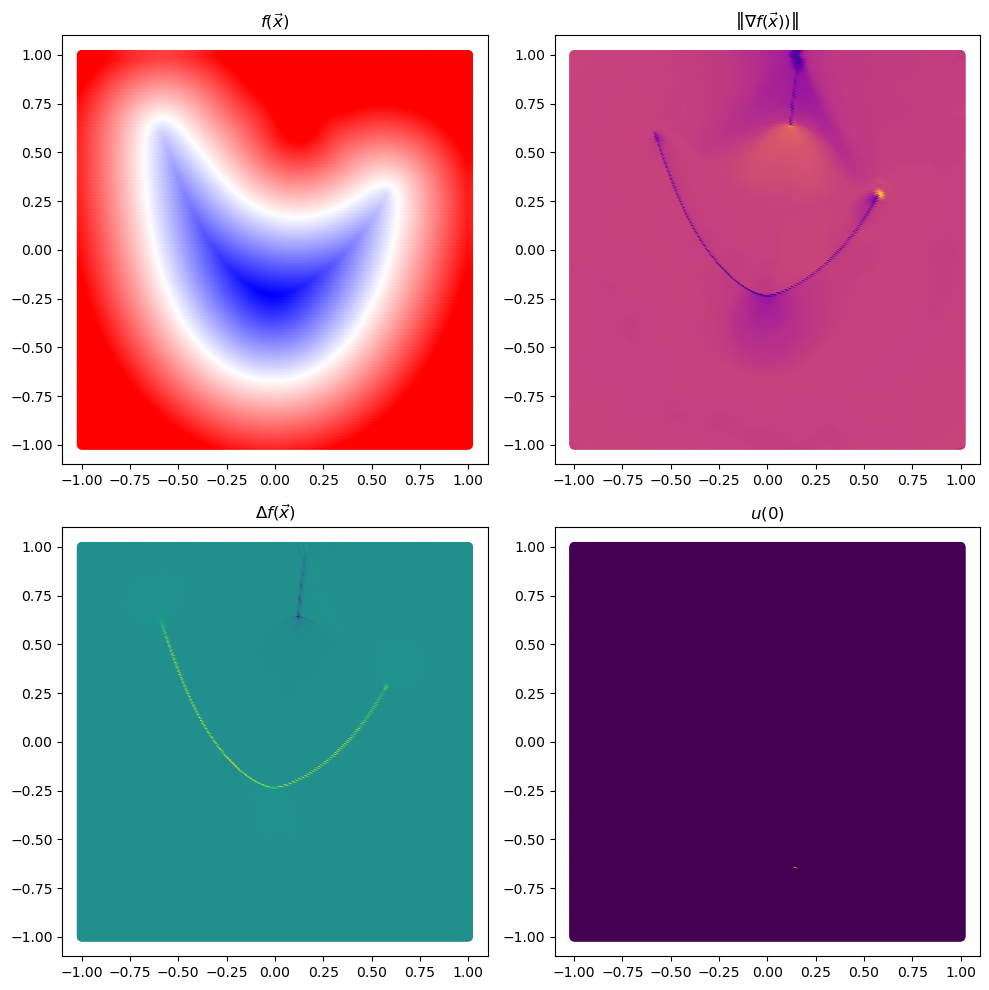

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
clip_val = min( np.abs(np.min(fX)), np.abs(np.max(fX)) )

axs[0][0].scatter(X[:,0], X[:,1], c=fX, cmap='bwr', vmin=-clip_val, vmax= clip_val)
axs[0][1].scatter(X[:,0], X[:,1], c=np.sum( dfX ** 2, axis=1), cmap='plasma')
axs[1][0].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[1][1].scatter(X[:,0], X[:,1], c=u0, cmap='viridis')

axs[0][0].set_title(r'$f(\vec{x})$')
axs[0][1].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1][0].set_title(r'$\Delta f(\vec{x})$')
axs[1][1].set_title(r'$u(0)$')

plt.tight_layout()
plt.show()

In [5]:
def integrator( L, u0, t, steps=1, method='backward'):
    I = sparse.csr_matrix( (N**2, N**2) )
    I.setdiag( np.ones(N ** 2), k=0 )

    ut = u0

    for step in range(steps):
        if method=='forward':
            ut = (I + t * L) @ ut
        
        elif method == 'backward':
            ut = sparse.linalg.spsolve( (I - t * L ), ut )
        
        elif method =='rk4':
            k1 = (L) @ ut
            k2 = (L) @ (ut + 0.5 * t * k1)
            k3 = (L) @ (ut + 0.5 * t * k2)
            k4 = (L) @ (ut + t * k3)
            
            ut = ut + (t/6) * (k1 + 2*k2 + 2*k3 + k4)
        
        else:
            raise ValueError('Uknown integrator method')
    
    return ut


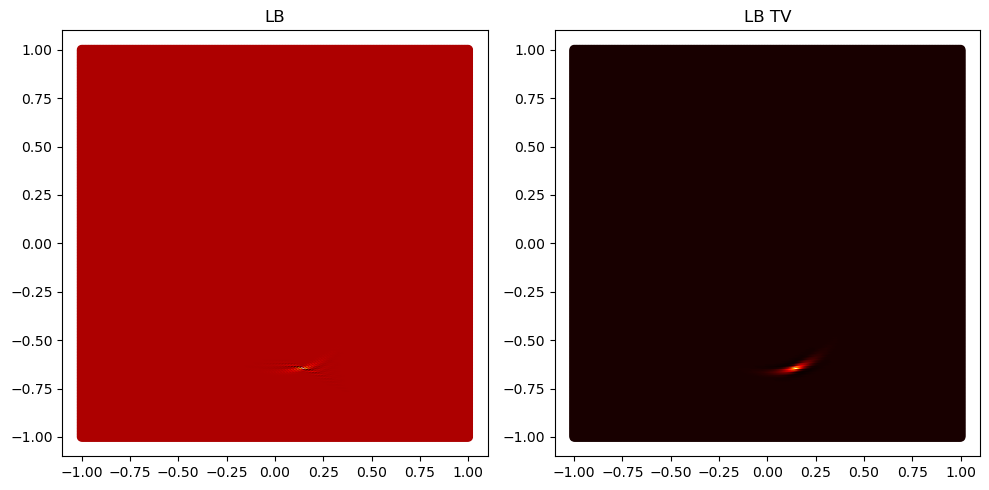

In [6]:
LB = gridLaplaceBeltramiBertalmio(N, fX, boundary='dirichlet' )
LB_TV = gridLaplaceBeltramiTV( N, dfX, LfX, tv, boundary='dirichlet' )

h = 2 / (N-1)
t = h ** 2 * 50

ut = integrator( LB, u0.flatten(), t, steps=1, method='backward' )
ut_TV = integrator( LB_TV, u0.flatten(), t, steps=1, method='backward' ) 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter( X[:, 0], X[:, 1], c=ut, cmap='hot')
axs[1].scatter( X[:, 0], X[:, 1], c=ut_TV, cmap='hot')

axs[0].set_title('LB')
axs[1].set_title('LB TV')

plt.tight_layout()
plt.show()

In [7]:
print( ut_TV.min(), ut_TV.max() )
print( ut.min(), ut.max() )

-0.0008069812133556307 0.03721019090213483
-0.04936742532013605 0.15339760965673016


0.15187043882699647 1.8437552944916074
0.20122416913384394 1.8437552944916074


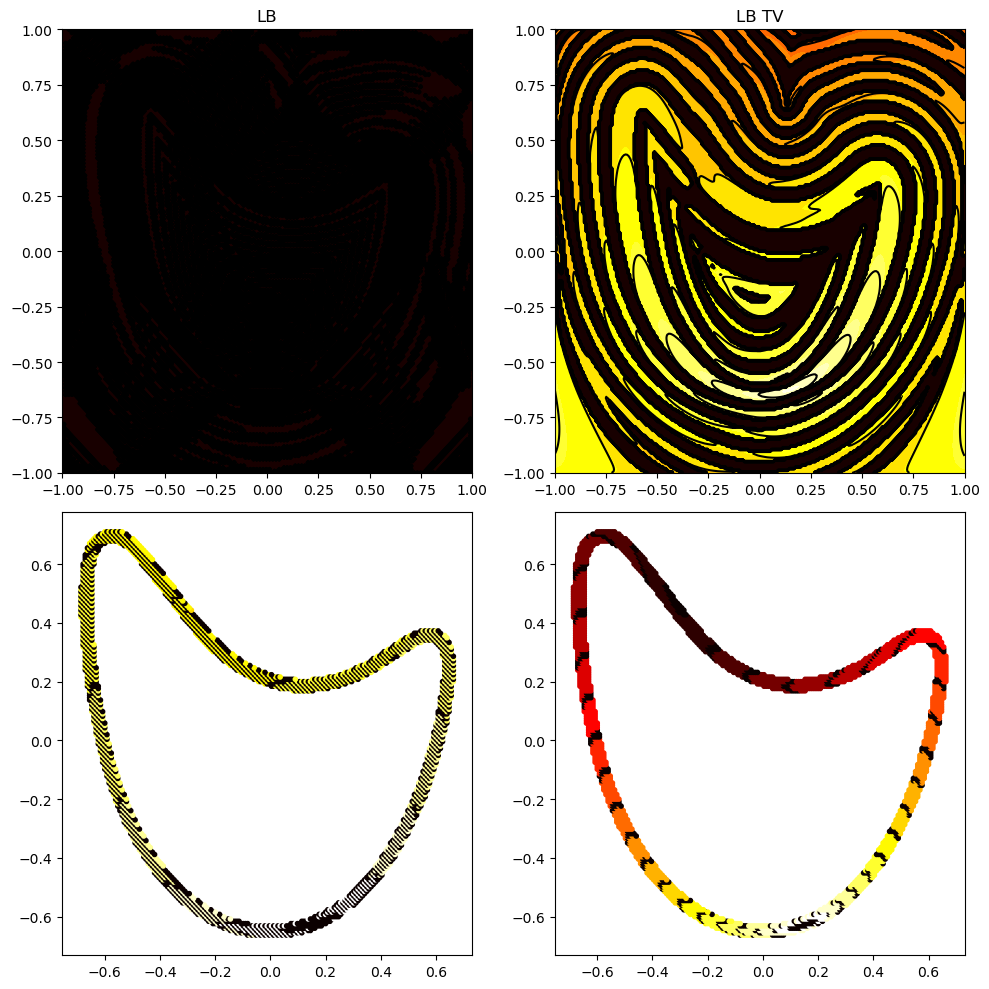

In [17]:
def contour( X, u, axis ):
    x_unique = np.unique(X[:, 0])
    y_unique = np.unique(X[:, 1])
    nx, ny = len(x_unique), len(y_unique)

    varadhan = np.sqrt( -4 * t * np.log( np.clip( u, a_min=1e-120, a_max=None ) ) )
    vmin, vmax = varadhan.min(), varadhan.max()
    print(vmin, vmax)
    u_grid = varadhan.reshape(ny, nx)

    num_levels = 20
    levels = np.linspace(vmin, vmax, num_levels)

    axis.contourf(x_unique, y_unique, u_grid, levels=21, cmap='hot_r')  
    axis.contour(x_unique, y_unique, u_grid, colors='black', levels=levels)

def contourMask( X, u, axis ):
    mask = np.abs(fX).flatten() < 0.02
    varadhan = np.sqrt( -4 * t * np.log( np.clip( u, a_min=1e-120, a_max=None ) ) )
    varadhan[mask] = np.clip( varadhan[mask], np.percentile( varadhan[mask],1), np.percentile( varadhan[mask],99) )
    vmin, vmax = varadhan[mask].min(), varadhan[mask].max()

    levels = np.linspace( vmin, vmax, 20)
    for i in range(len(levels) - 1):
        varadhan = np.where(
            np.abs(varadhan - levels[i]) < 0.005,
            np.ones_like(varadhan) * vmax,
            varadhan
        )

        varadhan = np.where(
            np.logical_and( varadhan - levels[i] > 0, varadhan - levels[i + 1] < 0 ),
            np.ones_like(varadhan) * levels[i],
            varadhan
        )

    axis.scatter( X[:,0][mask], X[:,1][mask], c=varadhan[mask],  marker='.',cmap='hot_r' )

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
contour( X, ut, axs[0][0])
contour( X, ut_TV, axs[0][1])
contourMask( X, ut, axs[1][0])
contourMask( X, ut_TV, axs[1][1])

axs[0][0].set_title('LB')
axs[0][1].set_title('LB TV')

plt.tight_layout()
plt.show()

/tmp/ipykernel_823316/3190133492.py:14: RuntimeWarning: divide by zero encountered in divide
  norm_nx = - ( nx ) / (norm)
/tmp/ipykernel_823316/3190133492.py:14: RuntimeWarning: invalid value encountered in divide
  norm_nx = - ( nx ) / (norm)
/tmp/ipykernel_823316/3190133492.py:15: RuntimeWarning: divide by zero encountered in divide
  norm_ny = - ( ny ) / (norm)
/tmp/ipykernel_823316/3190133492.py:15: RuntimeWarning: invalid value encountered in divide
  norm_ny = - ( ny ) / (norm)


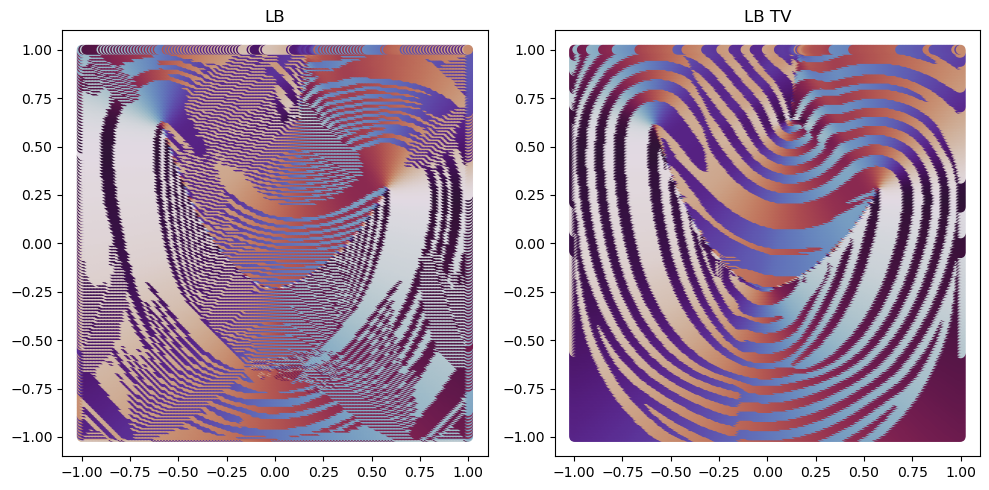

In [9]:
#Gx, Gy = gridDxMasked(N, np.abs(fX).flatten() < np.inf ), gridDyMasked(N, np.abs(fX).flatten() < np.inf)
Gx_i, Gy_i = gridIntrinsicGradient( N, dfX, boundary='neumann' )
Gx, Gy = gridInstrinsicGradientBertalmio( N, fX, boundary='neumann' )

nx_TV = Gx_i @ ut_TV
nx = Gx @ ut

ny_TV = Gy_i @ ut_TV
ny = Gy  @ ut

def normalmap( X, nx, ny, axis ):
    poissonMask = np.abs(fX).flatten() < np.inf
    norm = np.sqrt( nx ** 2 + ny ** 2 )
    norm_nx = - ( nx ) / (norm)
    norm_ny = - ( ny ) / (norm)
    
    angles = np.arctan2( -norm_nx, -norm_ny )
    
    norm = mcolors.Normalize(vmin=-np.pi, vmax=np.pi)
    angles_normalized = norm(angles)
    axis.scatter( X[:,0][poissonMask], X[:,1][poissonMask], c=angles_normalized[poissonMask], cmap='twilight' )

fig, axs = plt.subplots(1,2, figsize=(10, 5))
normalmap( X, nx, ny, axs[0])
normalmap( X, nx_TV, ny_TV, axs[1])

axs[0].set_title('LB')
axs[1].set_title('LB TV')

plt.tight_layout()
plt.show()

/tmp/ipykernel_823316/1270195068.py:3: RuntimeWarning: divide by zero encountered in divide
  norm_nx = - ( nx ) / (norm)
/tmp/ipykernel_823316/1270195068.py:3: RuntimeWarning: invalid value encountered in divide
  norm_nx = - ( nx ) / (norm)
/tmp/ipykernel_823316/1270195068.py:4: RuntimeWarning: divide by zero encountered in divide
  norm_ny = - ( ny ) / (norm)
/tmp/ipykernel_823316/1270195068.py:4: RuntimeWarning: invalid value encountered in divide
  norm_ny = - ( ny ) / (norm)
/tmp/ipykernel_823316/1270195068.py:12: RuntimeWarning: invalid value encountered in add
  b =  Gx @ norm_nx + Gy @ norm_ny


nan nan
[nan]
-0.04421238692529309 0.07220820173279419
[0.]


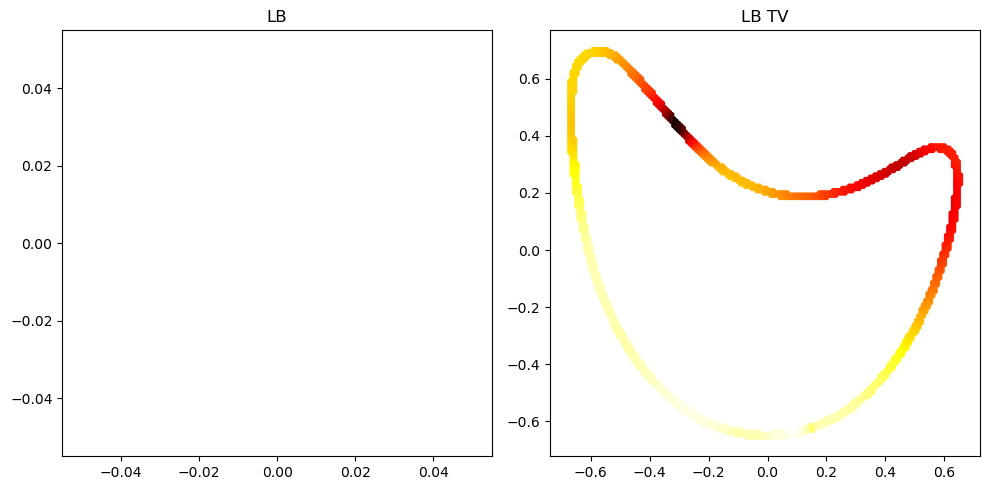

In [ ]:
def heatgeodesic( X, fX, nx, ny, axis, boundary='dirichlet' ):
    norm = np.sqrt( nx ** 2 + ny ** 2 )
    norm_nx = - ( nx ) / (norm)
    norm_ny = - ( ny ) / (norm)

    initialCondition = np.logical_not( u0 > 0.1 )

    L = gridLaplacianDirichlet( N, initialCondition )
    Gx = gridDx( N, boundary=boundary )
    Gy = gridDy( N, boundary=boundary ) 

    b =  Gx @ norm_nx + Gy @ norm_ny
    b[np.logical_not(initialCondition )] = 0
    
    phi = sparse.linalg.spsolve( L, b)
    print(phi.min(), phi.max())
    
    mask =  np.abs(fX).flatten() < 0.01

    #levels = np.linspace( phi[mask].min(), phi[mask].max(), 20)
    #for i in range(len(levels) - 1):
    #    phi = np.where(
    #        np.abs(phi - levels[i]) < 0.0005,
    #        np.ones_like(phi) * phi.max(),
    #        phi
    #    )
#
    #    phi = np.where(
    #        np.logical_and( phi - levels[i] > 0, phi - levels[i + 1] < 0 ),
    #        np.ones_like(phi) * levels[i],
    #        phi
    #    )

    axis.scatter( X[:,0][mask], X[:,1][mask], c=phi[mask],  marker='.',cmap='hot_r' )

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
heatgeodesic( X, fX, nx, ny, axs[0], boundary='dirichlet')
heatgeodesic( X, fX, nx_TV, ny_TV, axs[1], boundary='dirichlet')

axs[0].set_title('LB')
axs[1].set_title('LB TV')

plt.tight_layout()
plt.show()

In [ ]:
def heatgeodesic( X, fX, dfX, LfX, tv, ut, axis, boundary='dirichlet' ):
    PGx, PGy = gridIntrinsicGradient( N, dfX, boundary=boundary )
    vx = - (PGx @ ut)
    vy = - (PGy @ ut)
    
    v_norm = np.sqrt( vx ** 2 + vy ** 2 )

    LB = gridLaplaceBeltramiTV( N, dfX, LfX, tv, boundary=boundary )
    Gx = gridDx( N, boundary=boundary )
    Gy = gridDy( N, boundary=boundary ) 

    b = (LB @ ut) / v_norm - ( Gx @ v_norm * vx + Gy @ v_norm * vy ) / (v_norm ** 2)
    
    L = gridLaplacian( N, boundary=boundary )
    phi = sparse.linalg.spsolve( L, b)
    
    #mask = np.abs(fX).flatten() < 0.005
    mask =  np.abs(fX).flatten() < np.inf

    levels = np.linspace( phi[mask].min(), phi[mask].max(), 20)
    for i in range(len(levels) - 1):
        phi = np.where(
            np.abs(phi - levels[i]) < 0.05,
            np.ones_like(phi) * phi.max(),
            phi
        )
        phi = np.where(
            np.logical_and( phi - levels[i] > 0, phi - levels[i + 1] < 0 ),
            np.ones_like(phi) * levels[i],
            phi
        )

    axis.scatter( X[:,0][mask], X[:,1][mask], c=phi[mask],  marker='.',cmap='hot_r' )

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

heatgeodesic( X, fX, dfX, LfX, tv, ut_TV, axs, boundary='neumann')

axs.set_title('LB TV')

plt.tight_layout()
plt.show()

In [ ]:
def heatgeodesicFEM( X, fX, nx, ny, axis, boundary='dirichlet' ):
    norm = np.sqrt( nx ** 2 + ny ** 2 )
    norm_nx = - ( nx ) / (norm)
    norm_ny = - ( ny ) / (norm)

    #L = gridLaplaceBeltramiTV( N, dfX, LfX, tv, np.abs(fX).flatten() < np.inf, boundary=boundary )
    K = gridLaplacian( N, boundary=boundary )

    ones = np.ones(N**2)
    decoupled_ones = ones - (np.arange(1,N**2 + 1) % N == 0)
    M = sparse.diags([ ones * (h**2) / 2 ], [0], shape=(N**2, N**2), format='csr')

    M = sparse.diags([ decoupled_ones * (h**2) / 24 ], [1], shape=(N**2, N**2), format='csr')
    M = sparse.diags([ decoupled_ones * (h**2) / 24 ], [-1], shape=(N**2, N**2), format='csr')
    M = sparse.diags([ ones * (h**2) / 24 ], [-N], shape=(N**2, N**2), format='csr')
    M = sparse.diags([ ones * (h**2) / 24 ], [N], shape=(N**2, N**2), format='csr')
    M = sparse.diags([ decoupled_ones * (h**2) / 24 ], [-N - 1], shape=(N**2, N**2), format='csr')
    M = sparse.diags([ decoupled_ones * (h**2) / 24 ], [N + 1], shape=(N**2, N**2), format='csr')


    Gx = gridDx( N, boundary=boundary )
    Gy = gridDy( N, boundary=boundary )

    b = Gx @ norm_nx + Gy @ norm_ny 

    phi = sparse.linalg.spsolve( K, M @ b  )
    phi -= phi.min()
    phi /= phi.max()

    print( phi.min(), phi.max())
    mask = np.abs(fX).flatten() < 0.005

    levels = np.linspace( phi[mask].min(), phi[mask].max(), 20)
    for i in range(len(levels) - 1):
        phi = np.where(
            np.abs(phi - levels[i]) < 0.0005,
            np.ones_like(phi) * phi.max(),
            phi
        )
        phi = np.where(
            np.logical_and( phi - levels[i] > 0, phi - levels[i + 1] < 0 ),
            np.ones_like(phi) * levels[i],
            phi
        )

    axis.scatter( X[:,0][mask], X[:,1][mask], c=(phi)[mask],  marker='.',cmap='hot_r' )

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
#heatgeodesicFEM( X, fX, nx, ny, axs[0], boundary='dirichlet')
heatgeodesicFEM( X, fX, nx_TV, ny_TV, axs, boundary='dirichlet')

#axs[0].set_title('LB')
axs.set_title('LB TV')

plt.tight_layout()
plt.show()

## SfePy

In [ ]:
poissonMask = np.abs(fX).flatten() < 0.05

polygons = []
vertexIndexs = np.cumsum(poissonMask.astype(np.uint32) )
for i in np.arange( N**2 )[ poissonMask ]:
    if i % N == 0 or (i +1) % (N) == 0:
        continue

    if (
        i+1 < N**2 and poissonMask[i+1] == 1 and
        i+N+1 < N**2 and poissonMask[i+N+1] == 1 and
        i+N < N**2 and poissonMask[i+N] == 1 and
        i+1 < N**2 and poissonMask[i+1] == 1 
    ):
        
        polygons.append( [ 
            vertexIndexs[i],
            vertexIndexs[i+N],
            vertexIndexs[i+N+1],
            vertexIndexs[i+1], 
        ] )

print(vertexIndexs[12435])
print(len(polygons))

In [ ]:
vertexs = X[poissonMask, :]

In [ ]:
import numpy as np

def export_to_medit_mesh(filename, vertexs, polygons):
    """
    Exports the mesh data to a Medit mesh file format.

    Parameters:
    - filename: The name of the file to save the mesh to (e.g., 'square_1mm.mesh').
    - vertexs: A numpy array of shape (N, 2), where each row is a 2D vertex [x, y].
    - polygons: A numpy array of shape (M, 4), where each row contains indices of four vertices forming a quadrilateral.
    """
    with open(filename, 'w') as f:
        # Write header and dimension information
        f.write("MeshVersionFormatted 2\n")
        f.write("Dimension 2\n")
        
        # Write vertices
        f.write("Vertices\n")
        f.write(f"{len(vertexs)}\n")
        for vertex in vertexs:
            # Append '0' for the vertex label as required by the format
            f.write(f"{vertex[0]:.6e} {vertex[1]:.6e} 0\n")
        
        # Write quadrilaterals
        f.write("Quadrilaterals\n")
        f.write(f"{len(polygons)}\n")
        for quad in polygons:
            # Write indices for quadrilateral vertices + '1' for the polygon label
            f.write(f"{int(quad[0] )} {int(quad[1] )} {int(quad[2] )} {int(quad[3] )} 1\n")

    print(f"Mesh successfully saved to {filename}")

def export_to_obj_mesh(filename, vertexs, polygons):
    """
    Exports the mesh data to a Medit mesh file format.

    Parameters:
    - filename: The name of the file to save the mesh to (e.g., 'square_1mm.mesh').
    - vertexs: A numpy array of shape (N, 2), where each row is a 2D vertex [x, y].
    - polygons: A numpy array of shape (M, 4), where each row contains indices of four vertices forming a quadrilateral.
    """
    with open(filename, 'w') as f:
       
        for vertex in vertexs:
            f.write(f"v {vertex[0]:.6e} {vertex[1]:.6e} 0\n")
        
        for quad in polygons:
            f.write(f"f {int(quad[0] )} {int(quad[1] )} {int(quad[2])} {int(quad[3])} \n")

    print(f"Mesh successfully saved to {filename}")

export_to_medit_mesh("bezier2.mesh", vertexs, polygons)
export_to_obj_mesh("bezier2.obj", vertexs, polygons)

In [ ]:
import pyvista as pv

# Load the VTK file
mesh = pv.read("bezier2.vtk")
# Access the point data (solution at each vertex)
#vertex_solutions = mesh.point_data  # Replace with the actual field name
solution = mesh.point_data['u']
# Print or further process the solution
#print(vertex_solutions)

In [ ]:
plt.scatter( X[:,0][poissonMask], X[:,1][poissonMask], c=np.array(solution),  marker='.',cmap='hot_r' )